In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -q git+https://github.com/PyTorchLightning/pytorch-lightning
!pip install -q torchinfo

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 13.5 MB/s eta 0:00:00
     ━━━

In [2]:
import os
import pandas as pd
from sklearn.utils import shuffle

drive_dir = '/content/drive/MyDrive/Studia/Praca dyplomowa magisterska/'

dataset_dir = os.path.join(drive_dir, 'land-dataset/train/')

image_files = [
    os.path.join(dataset_dir, file)
    for file in os.listdir(dataset_dir)
    if file.endswith('.jpg')
]

mask_files = [
    os.path.join(dataset_dir, file)
    for file in os.listdir(dataset_dir)
    if file.endswith('.png')
]

df_dataset = pd.DataFrame({
    'images': sorted(image_files),
    'masks': sorted(mask_files)
})

df_dataset.sample()


,images,masks
156,/content/drive/MyDrive/Studia/Praca dyplomowa ...,/content/drive/MyDrive/Studia/Praca dyplomowa ...


3.2.2. Zbiór danych - grunty

In [3]:
class_dict = pd.read_csv(os.path.join(drive_dir, 'land-dataset/class_dict.csv'))

class_names = class_dict['name']
class_rgb_values = class_dict[['r', 'g', 'b']].values

print('Class names:', class_names.tolist())
print('Class RGB values:', class_rgb_values.tolist())

Class names: ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values: [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [ ]:
from sklearn.model_selection import train_test_split

df_train_dataset, df_val_dataset = train_test_split(df_dataset, test_size=0.2, random_state=0)
df_val_dataset, df_test_dataset = train_test_split(df_val_dataset, test_size=0.5, random_state=0)

print('Train dataset size:', len(df_train_dataset))
print('Validation dataset size:', len(df_val_dataset))
print('Test dataset size:', len(df_test_dataset))

Train dataset size: 642
Validation dataset size: 80
Test dataset size: 81


3.3.1. Augmentacja

In [ ]:
image_size = 512

In [ ]:
import albumentations as album

def get_training_augmentation():
    train_transform = [
        album.Resize(image_size, image_size),
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
        album.RandomBrightnessContrast(p=0.4),
    ]
    return album.Compose(train_transform)

def get_validation_augmentation():
    val_transform = [
        album.Resize(image_size, image_size),
        album.RandomBrightnessContrast(p=0.4)
    ]
    return album.Compose(val_transform)

In [ ]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

def visualize_dataset(dataset, visualize_augmentation=False):
    i = random.choice(dataset.index)

    image_path = dataset['images'].loc[i]
    mask_path = dataset['masks'].loc[i]

    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)

    num_subplots = 3 if visualize_augmentation else 4
    width_ratios = [1] * num_subplots if visualize_augmentation else [1, 1, 1, 0.05]

    fig, axes = plt.subplots(1, num_subplots, figsize=(4 * num_subplots, 4), gridspec_kw={'width_ratios': width_ratios})

    axes[0].set_title('Image')
    axes[0].imshow(image)

    axes[1].set_title('Mask')
    axes[1].imshow(mask)

    if visualize_augmentation:
        augmentation = get_training_augmentation()
        augmented_dataset = LandDataset(dataset, augmentation=augmentation)
        augmented_image, augmented_mask = augmented_dataset[i]

        axes[2].set_title('Augmented image')
        axes[2].imshow(augmented_image)

    else:
        category_labels = mask_to_category_labels(mask)

        axes[2].set_title('Category labels')
        im = axes[2].imshow(category_labels)

        cbar = fig.colorbar(im, ax=axes[2], ticks=np.arange(len(class_dict)), cax=axes[3])
        cbar.ax.set_yticklabels(class_dict['name'])

    plt.tight_layout()
    plt.show()

3.3.2. Konwersja masek do etykiet kategorii

In [ ]:
def mask_to_category_labels(mask):
    class_dict_arr = class_dict[['r', 'g', 'b']].values.astype(np.uint8)
    matches = np.all(mask == class_dict_arr[:, None, None], axis=-1)
    indices = np.argmax(matches, axis=0)
    category_labels = np.zeros(mask.shape[:2], dtype=np.int8)
    category_labels[matches.any(axis=0)] = indices[matches.any(axis=0)]

    return category_labels

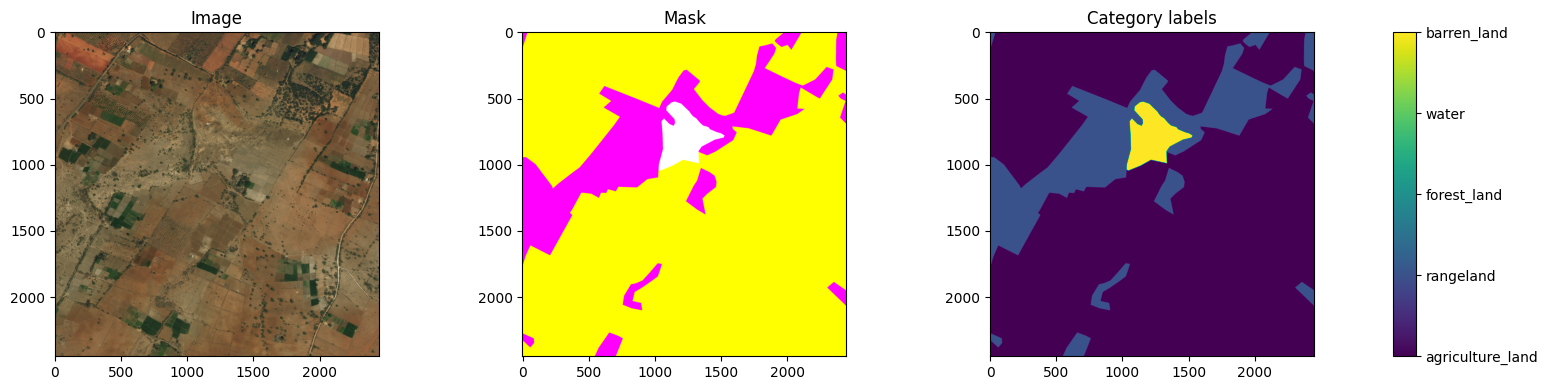

In [ ]:
visualize_dataset(df_dataset)

3.3.3. Przetwarzanie wstępne

In [ ]:
import torch

def image_to_tensor(image, **kwargs):
    image = np.transpose(image, (2, 0, 1)).astype(np.float64)
    image = torch.Tensor(image) / 255.0

    return image

def mask_to_tensor(mask, **kwargs):
    mask = np.expand_dims(mask, axis=0)
    mask = torch.Tensor(mask).long()

    return mask

def get_processing():
    transform = []
    transform.append(album.Lambda(image=image_to_tensor, mask=mask_to_tensor))

    return album.Compose(transform)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class LandDataset(Dataset):
    def __init__(self, df_dataset, augmentation=None, preprocessing=None):
        self.df_dataset = df_dataset
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, idx):
        row = self.df_dataset.iloc[idx]
        image = cv2.cvtColor(cv2.imread(row['images']), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(row['masks']), cv2.COLOR_BGR2RGB)

        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        mask = mask_to_category_labels(mask)

        if self.preprocessing:
            preprocessed = self.preprocessing(image=image, mask=mask)
            image, mask = preprocessed['image'], preprocessed['mask']

        return image, mask

    def __len__(self):
        return len(self.df_dataset)

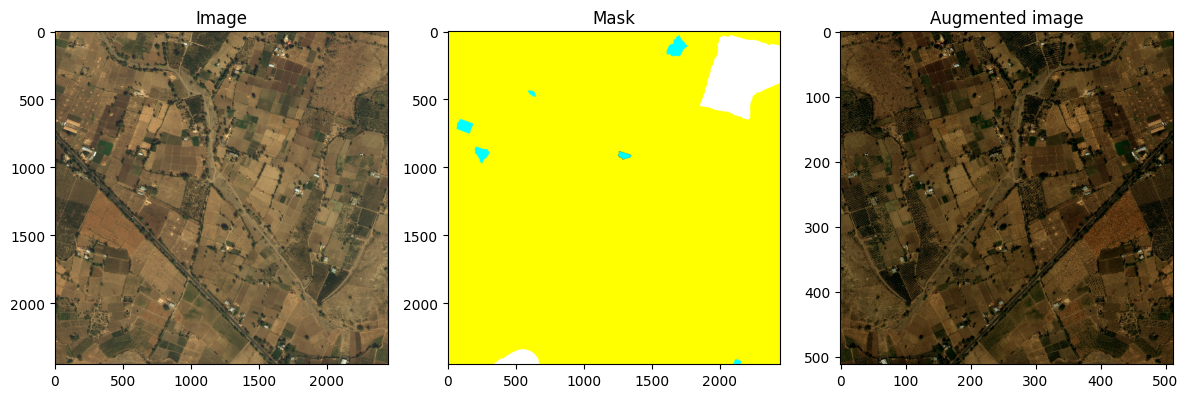

In [ ]:
visualize_dataset(df_dataset, True)

In [ ]:
train_dataset = LandDataset(df_train_dataset,
                            augmentation=get_training_augmentation(),
                            preprocessing=get_processing())
val_dataset = LandDataset(df_val_dataset,
                          augmentation=get_validation_augmentation(),
                          preprocessing=get_processing())
test_dataset = LandDataset(df_test_dataset,
                          augmentation=get_validation_augmentation(),
                          preprocessing=get_processing())

In [ ]:
batch_size = 8

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=12)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


3.3.4. Podsumowanie

In [ ]:
image, mask = next(iter(train_dataloader))
image.shape, mask.shape

(torch.Size([8, 3, 512, 512]), torch.Size([8, 1, 512, 512]))

3.4.1. Inicjalizacja modelu \\
3.4.2. Funkcja straty i metryki \\
3.4.3. Metoda propagacji w przód \\
3.4.4. Konfiguracja optymalizatora \\
3.4.5. Przebieg procesu

In [ ]:
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.metrics import get_stats, accuracy, iou_score, precision, recall, f1_score
import torch.optim as optim
import torch.nn as nn
import pytorch_lightning as pl

class LandModel(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.model = Unet(
            encoder_name='efficientnet-b7',
            encoder_weights='imagenet',
            in_channels=3,
            classes=num_classes,
            activation='softmax'
        )
        self.criterion = DiceLoss(mode="multiclass", from_logits=False, classes=list(range(num_classes)))
        self.metrics = {
            'accuracy': accuracy,
            'iou': iou_score,
            'precision': precision,
            'recall': recall,
            'f1score': f1_score
        }
        self.num_classes = num_classes
        self.true_classes = []
        self.pred_classes = []

    def forward(self, inputs, targets=None):
        outputs = self.model(inputs)
        if targets is not None:
            loss = self.criterion(outputs, targets)
            tp, fp, fn, tn = get_stats(outputs.argmax(dim=1).unsqueeze(1).type(torch.int64), targets, mode='multiclass', num_classes=self.num_classes)
            metrics = {
                key: metric(tp, fp, fn, tn, reduction='micro-imagewise')
                for key, metric in self.metrics.items()
            }
            return loss, metrics, outputs
        else:
            return outputs

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0001)

    def shared_step(self, batch, batch_idx, prefix):
        images, masks = batch
        loss, metrics, outputs = self(images, masks)
        if prefix == 'test':
            self.true_classes.append(masks.flatten().cpu().numpy())
            self.pred_classes.append(outputs.argmax(dim=1).flatten().cpu().numpy())
        log_dict = {f'{prefix}_loss': loss}
        log_dict.update({f'{prefix}_{k}': v for k, v in metrics.items()})
        self.log_dict(log_dict, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, 'train')

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, 'val')

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, 'test')


3.4.6. Podsumowanie

In [ ]:
from torchinfo import summary

model = LandModel(len(class_names))
summary(model, input_size=(batch_size, 3, image_size, image_size))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:05<00:00, 48.5MB/s]
/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


Layer (type:depth-idx)                                       Output Shape              Param #
LandModel                                                    [8, 7, 512, 512]          --
├─Unet: 1-1                                                  [8, 7, 512, 512]          --
│    └─EfficientNetEncoder: 2-1                              [8, 3, 512, 512]          1,643,520
│    │    └─Conv2dStaticSamePadding: 3-1                     [8, 64, 256, 256]         1,728
│    │    └─BatchNorm2d: 3-2                                 [8, 64, 256, 256]         128
│    │    └─MemoryEfficientSwish: 3-3                        [8, 64, 256, 256]         --
│    │    └─ModuleList: 3-4                                  --                        62,141,584
│    └─UnetDecoder: 2-2                                      [8, 16, 512, 512]         --
│    │    └─Identity: 3-5                                    [8, 640, 16, 16]          --
│    │    └─ModuleList: 3-6                                  --             

3.6. Trening i walidacja

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=8,
    mode='min'
)

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='landmodel-{epoch:02d}-{val_loss:.4f}',
    monitor='val_loss',
    mode='min'
)
logger_dir = os.path.join(drive_dir, 'metrics')
logger = CSVLogger(logger_dir)

trainer = Trainer(
    accelerator="gpu",
    max_epochs=100,
    callbacks=[early_stop_callback, checkpoint_callback],
    logger=logger,
    log_every_n_steps=1,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dataloader, val_dataloader)
trainer.test(model, test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type     | Params
---------------------------------------
0 | model     | Unet     | 67.1 M
1 | criterion | DiceLoss | 0     
---------------------------------------
67.1 M    Trainable params
0         Non-trainable params
67.1 M    Total params
268.385   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9630420804023743     │
│       test_f1score        │    0.8706473112106323     │
│         test_iou          │    0.7866048216819763     │
│         test_loss         │    0.2937585413455963     │
│      test_precision       │    0.8706473112106323     │
│        test_recall        │    0.8706473112106323     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2937585413455963,
  'test_accuracy': 0.9630420804023743,
  'test_iou': 0.7866048216819763,
  'test_precision': 0.8706473112106323,
  'test_recall': 0.8706473112106323,
  'test_f1score': 0.8706473112106323}]

In [ ]:
model_dir = os.path.join(drive_dir, 'land-model.pth')
torch.save(model.state_dict(), model_dir)

In [ ]:
model_dir = os.path.join(drive_dir, 'land-model.pth')
model.load_state_dict(torch.load(model_dir))

<All keys matched successfully>

4.1. Testowanie

In [ ]:
trainer.test(model, test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9629433751106262     │
│       test_f1score        │    0.8703019618988037     │
│         test_iou          │    0.7846923470497131     │
│         test_loss         │    0.2779912054538727     │
│      test_precision       │    0.8703019618988037     │
│        test_recall        │    0.8703019618988037     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2779912054538727,
  'test_accuracy': 0.9629433751106262,
  'test_iou': 0.7846923470497131,
  'test_precision': 0.8703019618988037,
  'test_recall': 0.8703019618988037,
  'test_f1score': 0.8703019618988037}]

3.6. Trening i walidacja

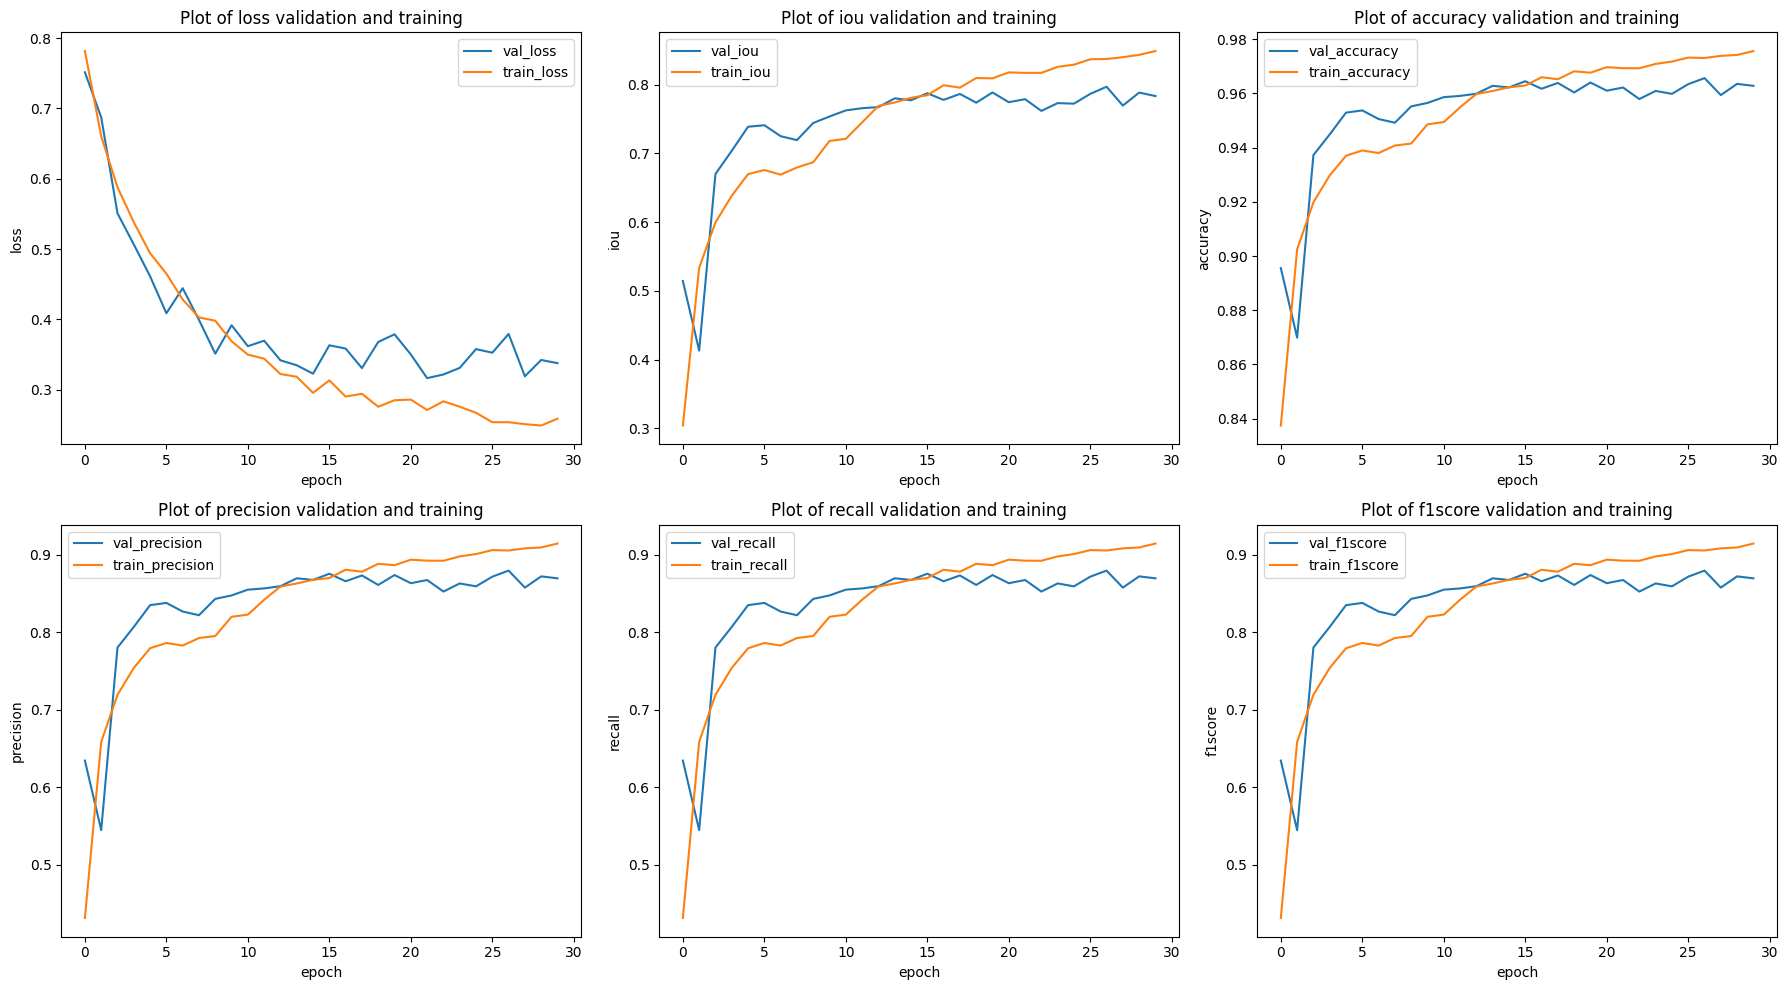

In [ ]:
def plot_metric(df, metric_name, ax):
    df = df.set_index('epoch')

    ax.plot(df[f'val_{metric_name}'].dropna(), label=f'val_{metric_name}')
    ax.plot(df[f'train_{metric_name}'].dropna(), label=f'train_{metric_name}')

    ax.set_title(f'Plot of {metric_name} validation and training')
    ax.set_xlabel('epoch')
    ax.set_ylabel(metric_name)
    ax.legend()

metrics_dir = os.path.join(drive_dir, 'metrics/lightning_logs/version_28/metrics.csv')
df = pd.read_csv(metrics_dir)

metric_names = ['loss', 'iou', 'accuracy', 'precision', 'recall', 'f1score']

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for axis, metric_name in zip(axes, metric_names):
    plot_metric(df, metric_name, axis)

plt.tight_layout()
plt.show()


In [ ]:
def category_labels_to_mask(category_labels):
    class_dict_arr = class_dict[['r', 'g', 'b']].values.astype(np.uint8)
    mask = class_dict_arr[category_labels]

    return mask

4.2. Przewidywane maski

/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


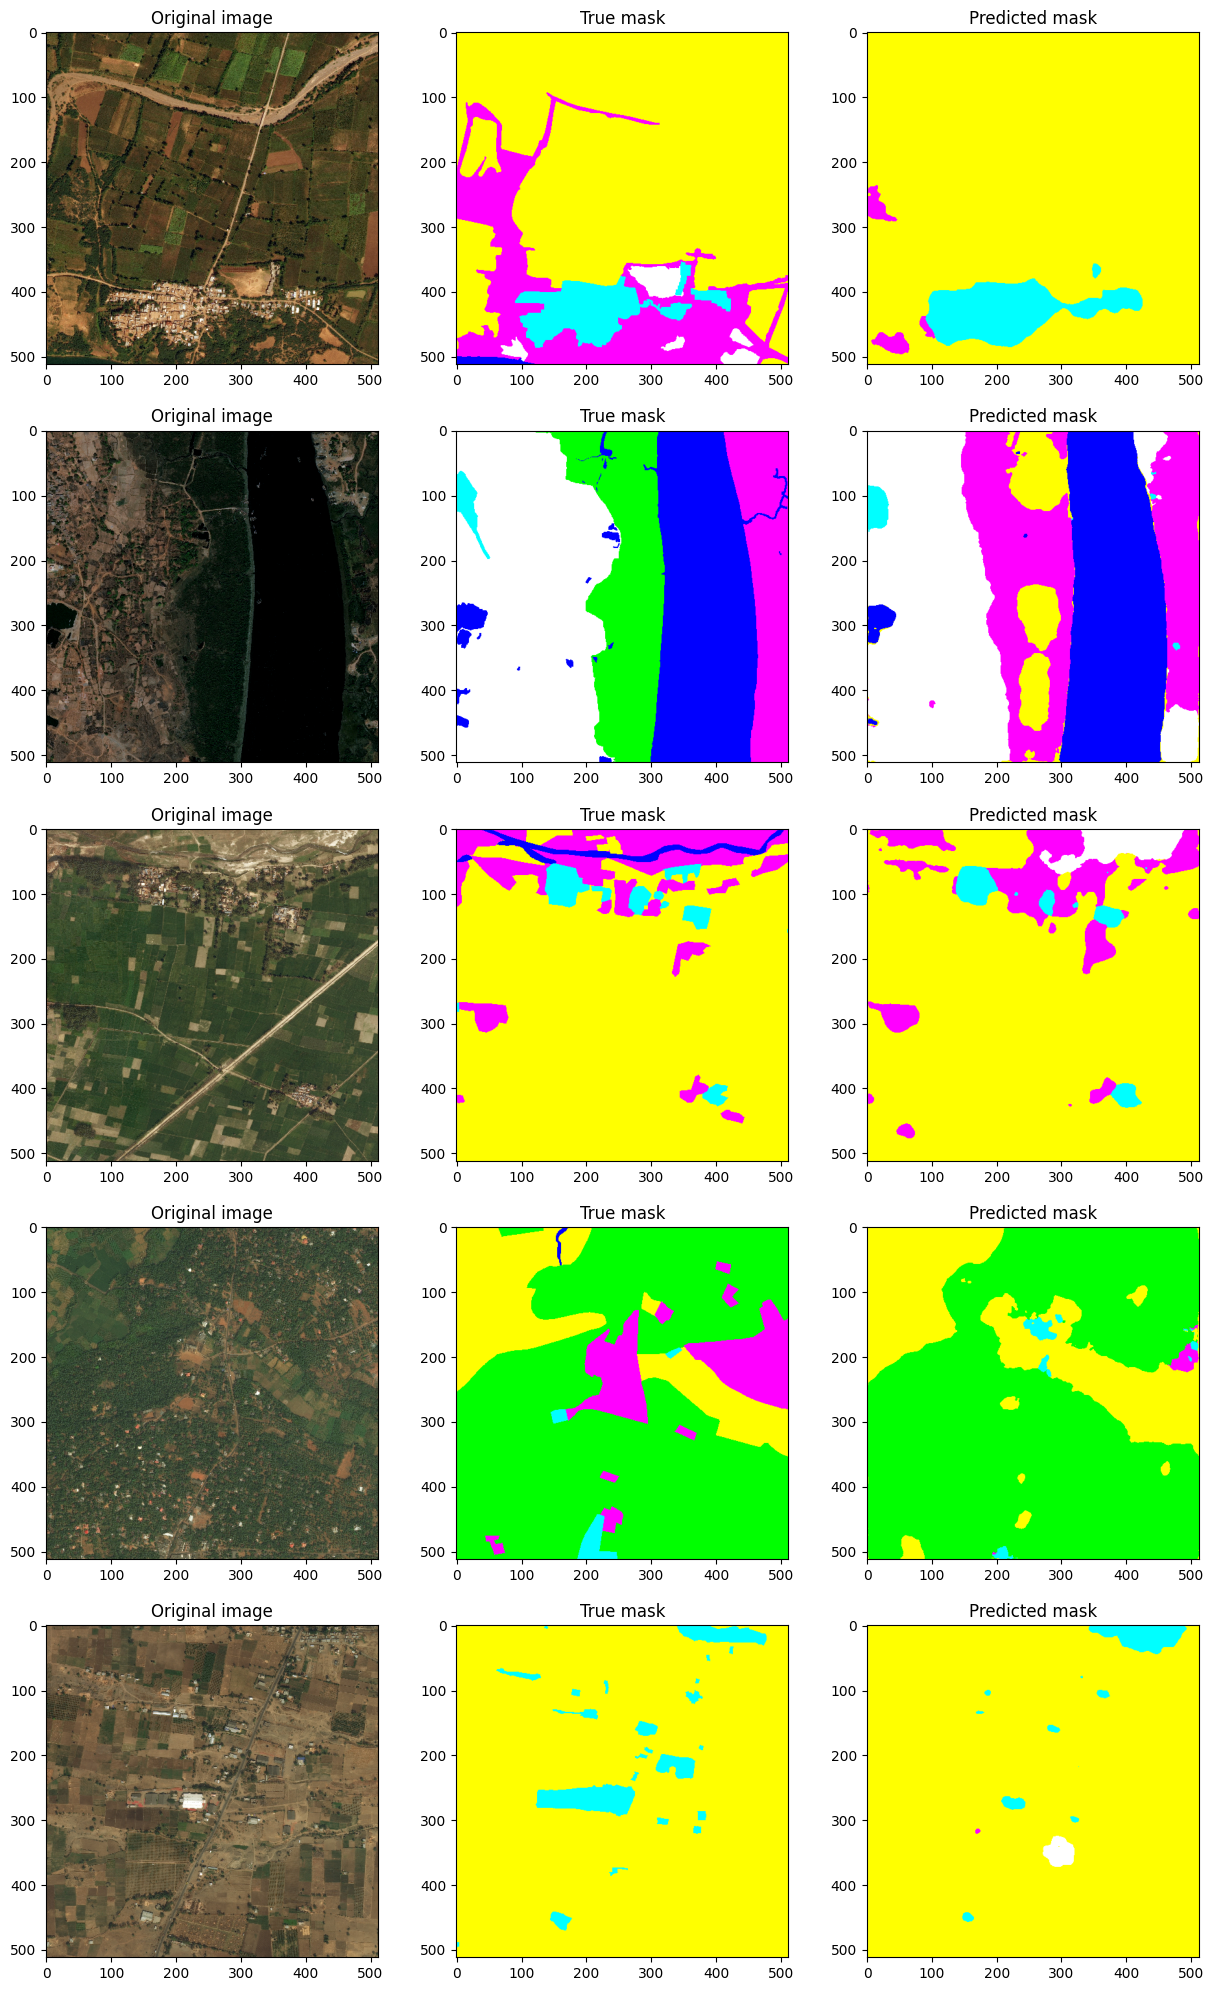

In [ ]:
def plot_predicted_masks(images, true_masks, predicted_masks, num_images=5):
    fig, axs = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))

    for idx, (img, true_mask, pred_mask) in enumerate(zip(images, true_masks, predicted_masks)):
        if idx >= num_images:
            break

        img = img.permute(1, 2, 0).cpu().numpy()
        true_mask = category_labels_to_mask(true_mask.squeeze(0).cpu().numpy())
        pred_mask = category_labels_to_mask(torch.argmax(pred_mask, dim=0).cpu().numpy())

        axs[idx, 0].imshow(img)
        axs[idx, 0].set_title('Original image')

        axs[idx, 1].imshow(true_mask)
        axs[idx, 1].set_title('True mask')

        axs[idx, 2].imshow(pred_mask)
        axs[idx, 2].set_title('Predicted mask')

    plt.show()

test_images, test_masks = next(iter(test_dataloader))
predicted_masks = model(test_images)
plot_predicted_masks(test_images, test_masks, predicted_masks)


4.3. Macierze pomyłek

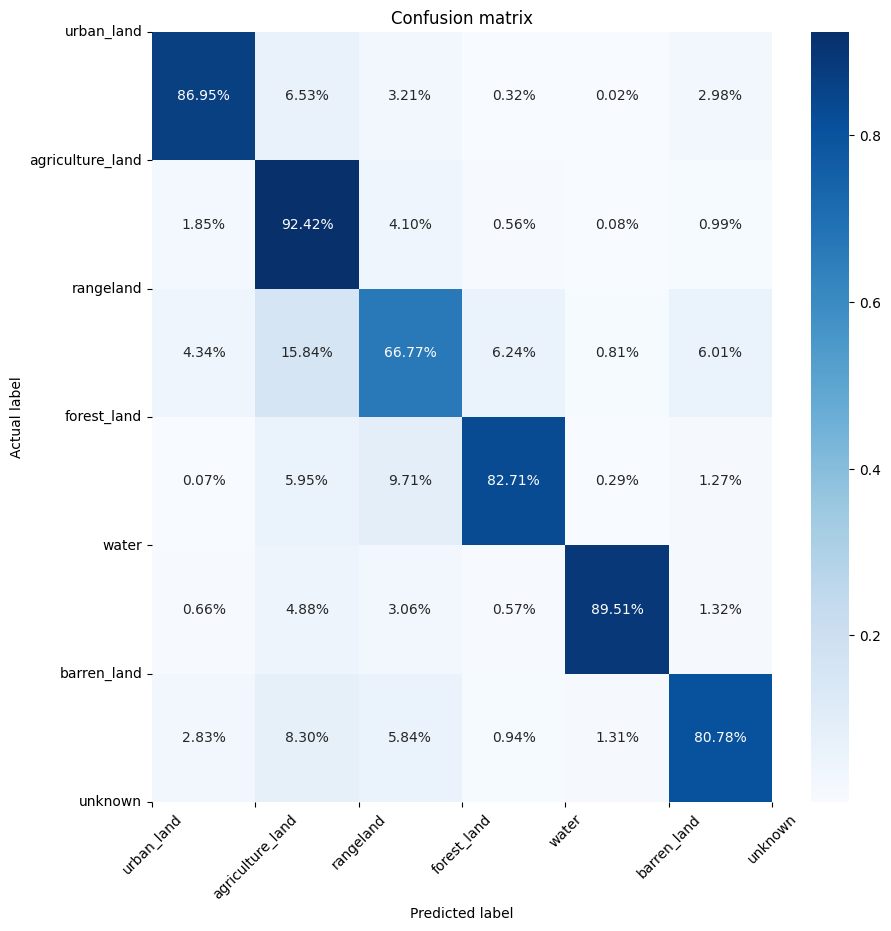

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_classes = np.concatenate(model.true_classes)
pred_classes = np.concatenate(model.pred_classes)

cm = confusion_matrix(true_classes, pred_classes)
cm = cm[:-1, :-1]

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.xticks(np.arange(len(class_names.tolist())), class_names.tolist(), rotation=45)
plt.yticks(np.arange(len(class_names.tolist())), class_names.tolist(), rotation=0)

plt.show()


4.4. Wektoryzacja

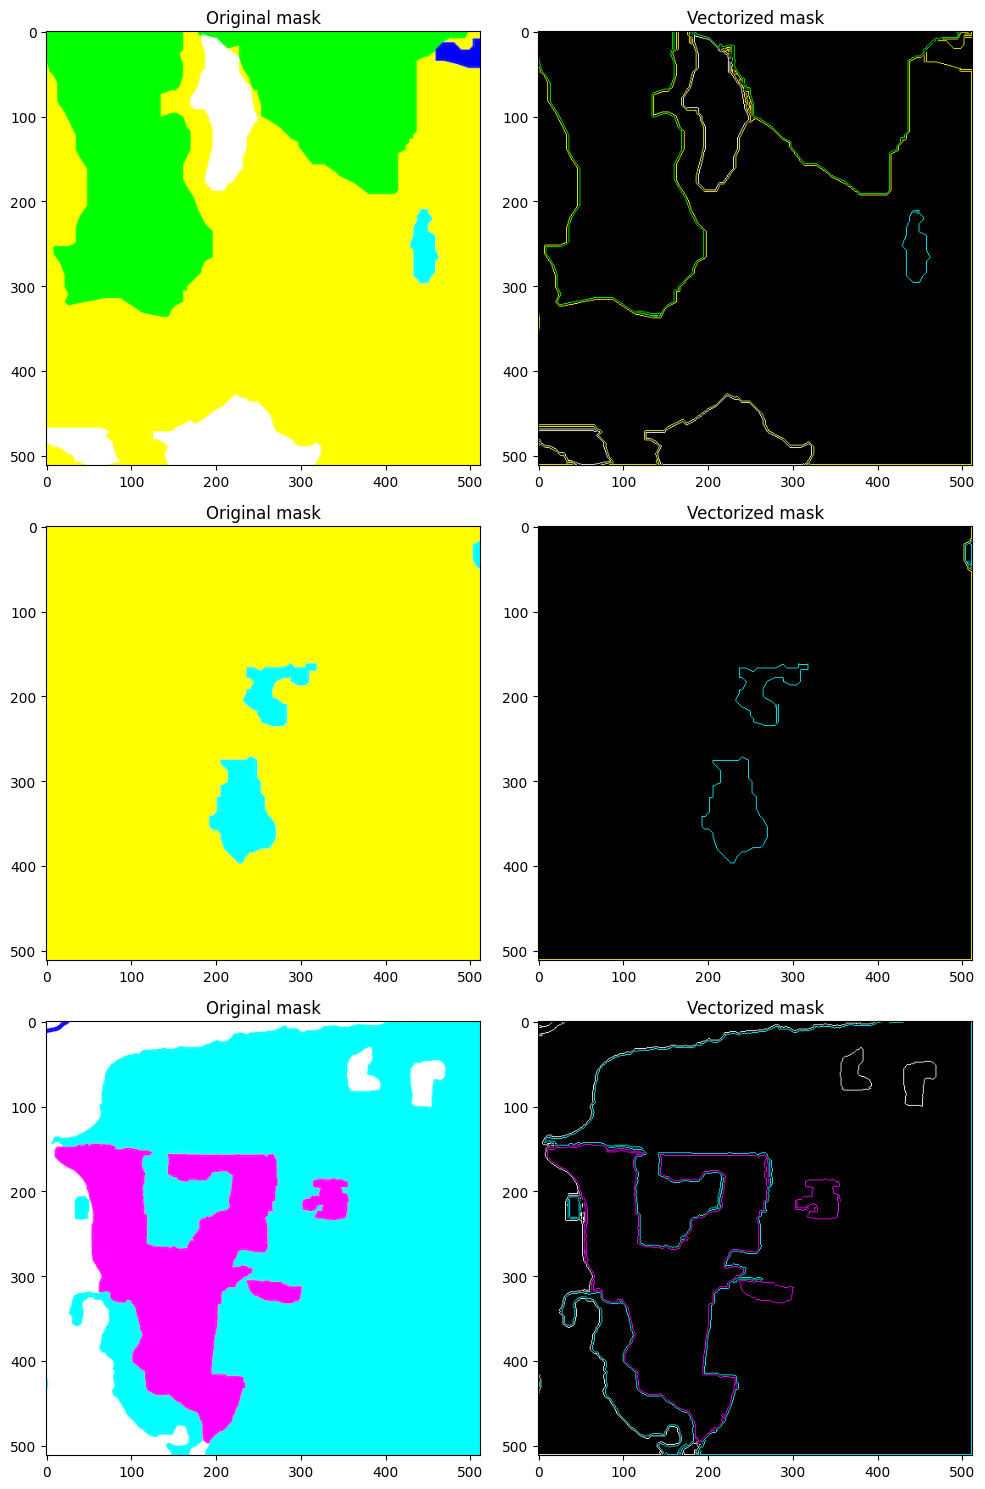

In [16]:
import cv2
import numpy as np
import random
import sqlite3
import matplotlib.pyplot as plt

def save_vectorized_mask_to_db(mask_path, db_connection, output_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    contours_per_class = []

    for rgb_value in class_rgb_values:
        class_mask = np.all(mask == rgb_value, axis=-1)
        class_contours, _ = cv2.findContours(class_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours_per_class.append((class_contours, rgb_value))

    contour_mask = np.zeros_like(mask, dtype=np.uint8)
    for class_contours, rgb_value in contours_per_class:
        if class_contours:
            epsilon = 0.0001 * cv2.arcLength(class_contours[0], True)
            polygons = [cv2.approxPolyDP(contour, epsilon, closed=True) for contour in class_contours]

            color = np.array(rgb_value, dtype=np.uint8)
            cv2.drawContours(contour_mask, polygons, -1, color.tolist(), 1)

    cv2.imwrite(output_path, contour_mask)

    flattened_mask = contour_mask.flatten()

    cursor = db_connection.cursor()
    cursor.execute("INSERT INTO masks (mask_vector) VALUES (?)", (flattened_mask,))
    db_connection.commit()

mask_dir = os.path.join(drive_dir, 'land-sample/')
vectorized_dir = os.path.join(drive_dir, 'land-vectorized/')
db_dir = os.path.join(drive_dir, 'land_masks.db')

db_connection = sqlite3.connect(db_dir)
cursor = db_connection.cursor()
cursor.execute("CREATE TABLE IF NOT EXISTS masks (mask_vector BLOB)")
db_connection.commit()

mask_files = [file for file in os.listdir(mask_dir) if file.startswith("predicted_mask_") and file.endswith(".png")]

for mask_file in mask_files:
    mask_path = os.path.join(mask_dir, mask_file)
    output_path = os.path.join(vectorized_dir, mask_file)
    save_vectorized_mask_to_db(mask_path, db_connection, output_path)

db_connection.close()

random_masks = random.sample(mask_files, 3)

plt.figure(figsize=(10, 15))
for i, mask_file in enumerate(random_masks):
    mask_path = os.path.join(mask_dir, mask_file)
    vectorized_mask_path = os.path.join(vectorized_dir, mask_file)

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    vectorized_mask = cv2.imread(vectorized_mask_path, cv2.IMREAD_COLOR)

    plt.subplot(3, 2, i * 2 + 1)
    plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
    plt.title(f"Original mask")

    plt.subplot(3, 2, i * 2 + 2)
    plt.imshow(cv2.cvtColor(vectorized_mask, cv2.COLOR_BGR2RGB))
    plt.title(f"Vectorized mask")

plt.tight_layout()
plt.show()


In [15]:
import sqlite3

db_dir = os.path.join(drive_dir, 'land_masks.db')
db_connection = sqlite3.connect(db_dir)

cursor = db_connection.cursor()

cursor.execute("SELECT mask_vector FROM masks")
mask_vectors = cursor.fetchall()

db_connection.close()
mask_vectors[2]

Output hidden; open in https://colab.research.google.com to view.